In [1]:
# Dependencies and Setup
%matplotlib inline
%matplotlib widget
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Hide warning messages in notebook
import warnings
warnings.filterwarnings('ignore')

# File to Load (Remember to Change These)
mouse_drug_data_to_load = "../../UNCRAL20190514DATA/02-Homework/05-Matplotlib/Instructions/Pymaceuticals/data/mouse_drug_data.csv"
clinical_trial_data_to_load = "../../UNCRAL20190514DATA/02-Homework/05-Matplotlib/Instructions/Pymaceuticals/data/clinicaltrial_data.csv"

# Read the Mouse and Drug Data and the Clinical Trial Data
mousedat = pd.read_csv(mouse_drug_data_to_load)
clindat  = pd.read_csv(clinical_trial_data_to_load)

In [2]:
# Check uniqueness
unique_check = mousedat
unique_check["Count"] = 1
sums = unique_check.groupby(["Mouse ID", "Drug"]).sum().groupby("Mouse ID").sum()

# If a mouse shows up in dups, it means they were dosed with more than one drug
problems = sums.loc[sums["Count"] > 1]
dups = problems.merge(mousedat, how="left", on="Mouse ID")["Mouse ID"].tolist()

# This is not a crossover trial, so this mouse must be removed
if len(dups)>0:
    clean_mousedat = mousedat.loc[ ~(mousedat["Mouse ID"].isin(dups)) ]
else:
    clean_mousedat = mousedat

In [3]:
# Combine the data into a single dataset
alldat = clindat.merge(clean_mousedat, on="Mouse ID", how="right")

# Display the data table for preview
alldat.head(5)

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug,Count
0,b128,0,45.000000,0,Capomulin,1
1,b128,5,45.651331,0,Capomulin,1
2,b128,10,43.270852,0,Capomulin,1
3,b128,15,43.784893,0,Capomulin,1
4,b128,20,42.731552,0,Capomulin,1


## Tumor Response to Treatment

In [4]:
# Store the Mean Tumor Volume Data Grouped by Drug and Timepoint 
mean_d_t = alldat.groupby(["Drug", "Timepoint"]).mean()[["Tumor Volume (mm3)", "Metastatic Sites"]]

# Preview DataFrame
mean_d_t.head(5)


Tumor Volume (mm3)  Metastatic Sites
Drug      Timepoint                                      
Capomulin 0                   45.000000          0.000000
          5                   44.266086          0.160000
          10                  43.084291          0.320000
          15                  42.064317          0.375000
          20                  40.716325          0.652174

In [5]:
# Store the Standard Error of Tumor Volumes Grouped by Drug and Timepoint
sem_d_t = alldat.groupby(["Drug", "Timepoint"]).sem()[["Tumor Volume (mm3)", "Metastatic Sites"]]

# Preview DataFrame
sem_d_t.head(5)

Tumor Volume (mm3)  Metastatic Sites
Drug      Timepoint                                      
Capomulin 0                    0.000000          0.000000
          5                    0.448593          0.074833
          10                   0.702684          0.125433
          15                   0.838617          0.132048
          20                   0.909731          0.161621

In [6]:
# Minor Data Munging to Re-Format the Data Frames
mean_d_t["Tumor Volume (mm3)"] = mean_d_t["Tumor Volume (mm3)"].map("{:,.1f}".format) 
mean_d_t["Metastatic Sites"] = mean_d_t["Metastatic Sites"].map("{:,.1f}".format) 

sem_d_t["Tumor Volume (mm3)"] = sem_d_t["Tumor Volume (mm3)"].map("{:,.2f}".format) 
sem_d_t["Metastatic Sites"] = sem_d_t["Metastatic Sites"].map("{:,.2f}".format) 

# Preview that Reformatting worked
sem_d_t.head()

Tumor Volume (mm3) Metastatic Sites
Drug      Timepoint                                    
Capomulin 0                       0.00             0.00
          5                       0.45             0.07
          10                      0.70             0.13
          15                      0.84             0.13
          20                      0.91             0.16

In [100]:
# Pivot the values
def pivot_df(source, value):
    source = source.reset_index(level=[0, 1])
    return source.pivot(index="Timepoint", columns="Drug", values=value)

# Nothing will graph properly if it isn't numeric
mean_tumor = pivot_df(mean_d_t, "Tumor Volume (mm3)").apply(pd.to_numeric)
mean_metastatic = pivot_df(mean_d_t, "Metastatic Sites").apply(pd.to_numeric)
sem_tumor = pivot_df(sem_d_t, "Tumor Volume (mm3)").apply(pd.to_numeric)
sem_metastatic = pivot_df(sem_d_t, "Metastatic Sites").apply(pd.to_numeric)

sorted_tumor = mean_tumor.iloc[-1].sort_values().index.tolist()
sorted_metastatic = mean_metastatic.iloc[-1].sort_values().index.tolist()

timepoints = mean_tumor.index.tolist()

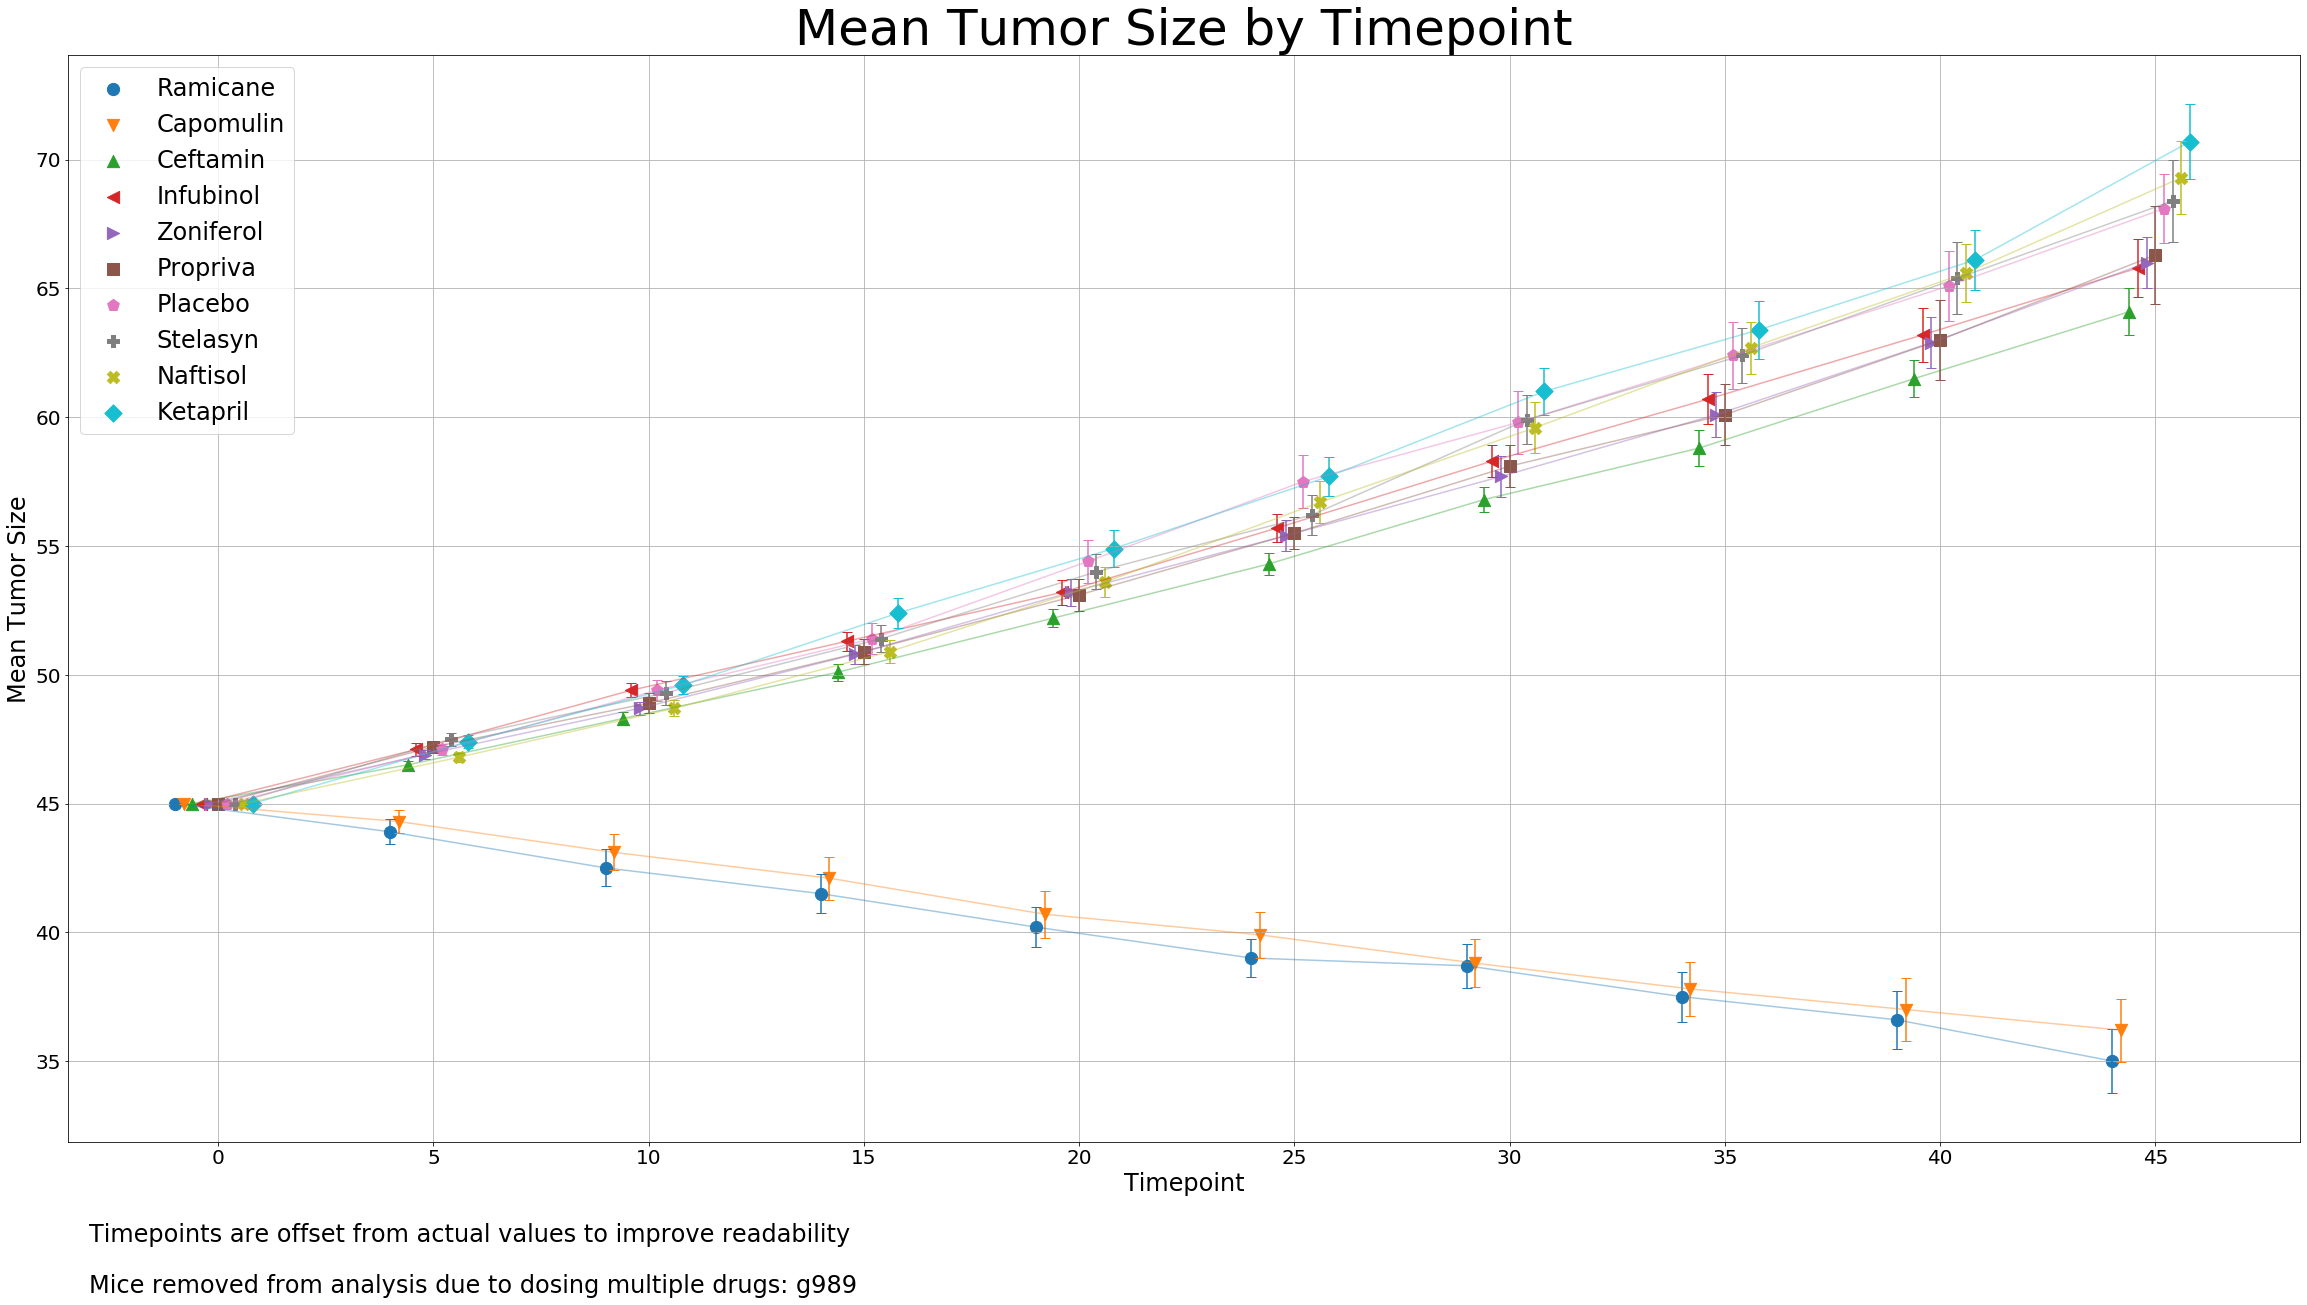

In [151]:
# Generate the Plot (with Error Bars)

# Ensure consistent formatting
formatting = [
    {"color": "C0", "symbol": "o"},
    {"color": "C1", "symbol": "v"},
    {"color": "C2", "symbol": "^"},
    {"color": "C3", "symbol": "<"},
    {"color": "C4", "symbol": ">"},
    {"color": "C5", "symbol": "s"},
    {"color": "C6", "symbol": "p"},
    {"color": "C7", "symbol": "P"},
    {"color": "C8", "symbol": "X"},
    {"color": "C9", "symbol": "D"},
]

fig, ax = plt.subplots()
fig.set_figheight(20)
fig.set_figwidth(40)
ax.grid()
ax.set_xticks(timepoints)
ax.set_xlabel("Timepoint", fontsize=24)
ax.set_ylabel("Mean Tumor Size", fontsize=24)
ax.set_title("Mean Tumor Size by Timepoint", fontsize=50)
ax.tick_params(labelsize=20)

# NOTE: Applying slight offsets to scatter so data do not overlap
for index, drug in enumerate(sorted_tumor):
    ax.plot(mean_tumor.index - 1 + 0.2*index, 
            mean_tumor[drug],
            color = formatting[index]["color"],
            alpha = 0.4)
    ax.scatter(mean_tumor.index - 1 + 0.2*index,
               mean_tumor[drug],
               s = 150,
               c = formatting[index]["color"],
               marker = formatting[index]["symbol"],
               label=drug)
    ax.errorbar(mean_tumor.index - 1 + 0.2*index,
                mean_tumor[drug],
                yerr = sem_tumor[drug],
                ecolor = formatting[index]["color"],
                capsize = 5,
                ls = 'none')

ax.legend(fontsize=24)
ax.text(-3, 28, "Timepoints are offset from actual values to improve readability", ha='left', fontsize=24)
if len(dups) > 0:
    ax.text(-3, 26, f"Mice removed from analysis due to dosing multiple drugs: {'; '.join(set(dups))}", ha='left', fontsize=24)
# Need to add another footnote about the removed mouse

# Save the Figure
plt.savefig('mean_tumor.png')

In [144]:
# Show the Figure
plt.show()

{'g989'}

## Metastatic Response to Treatment

In [10]:
# Store the Mean Met. Site Data Grouped by Drug and Timepoint 

# Convert to DataFrame

# Preview DataFrame


In [11]:
# Store the Standard Error associated with Met. Sites Grouped by Drug and Timepoint 

# Convert to DataFrame

# Preview DataFrame


In [12]:
# Minor Data Munging to Re-Format the Data Frames

# Preview that Reformatting worked


In [13]:
# Generate the Plot (with Error Bars)

# Save the Figure

# Show the Figure


## Survival Rates

In [14]:
# Store the Count of Mice Grouped by Drug and Timepoint (W can pass any metric)

# Convert to DataFrame

# Preview DataFrame


In [15]:
# Minor Data Munging to Re-Format the Data Frames

# Preview the Data Frame


In [16]:
# Generate the Plot (Accounting for percentages)

# Save the Figure

# Show the Figure
plt.show()

## Summary Bar Graph

In [17]:
# Calculate the percent changes for each drug

# Display the data to confirm


In [18]:
# Store all Relevant Percent Changes into a Tuple


# Splice the data between passing and failing drugs


# Orient widths. Add labels, tick marks, etc. 


# Use functions to label the percentages of changes


# Call functions to implement the function calls


# Save the Figure


# Show the Figure
fig.show()